This notebook focuses on trying to find a way to segment cells within organoids properly.
The end goals is to segment cell and extract morphology features from cellprofiler.
These masks must be imported into cellprofiler to extract features.

In [ ]:
import argparse
import pathlib
import shutil
import subprocess  # subprocess handling
import sys

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import skimage
import tifffile
import torch
import tqdm
from cellpose import core, models
from skimage import io

use_GPU = torch.cuda.is_available()

cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd
else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break
sys.path.append(str(root_dir / "utils/"))
from arg_parsing_utils import check_for_missing_args, parse_args
from notebook_init_utils import bandicoot_check, init_notebook

root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(pathlib.Path("~/mnt/bandicoot").resolve(), root_dir)

In [ ]:
def segment_with_diameter(
    img: np.ndarray,
    model: models.Cellpose,
    diameter: int,
    z_axis: int = 0,
    channels: tuple = [1, 0],
    min_diameter: int = 200,  # in pixels, default is 200
    diameter_step: int = 200,
) -> tuple:
    """
    Recursively perform segmentation, stepping down through diameters by 200
    until a valid label is found or the minimum diameter is reached.
    This effectively performs a dynamic search for the largest detectable object
    in the image.

    Parameters
    ----------
    img : np.ndarray
        The image to segment. Can be 3D in the format of (z, y, x).
    model : models.Cellpose
        The Cellpose model to use for segmentation.
    diameter : int
        The diameter to use for segmentation.
        This is where the search starts.
    z_axis : int, optional
        The axis of the z-stack. Default is axis 0.
    channels : tuple, optional
        The channels to use for segmentation. Default is (1, 0).
        Where 1 is the channel for the cytoplasm and 0 using no other channel.
    min_diameter : int, optional
        The minimum diameter to use for segmentation.
        If the diameter is less than this, the function will return empty labels.
        Default is 200 pixels.
    diameter_step : int, optional
        The step size to decrease the diameter by when no labels are found.
        Default is 200 pixels.

    Returns
    -------
    tuple
        labels : np.ndarray
            The labels of the segmented image.
        details : dict
            The details of the segmentation.
        _ : None
            Placeholder for additional return values.
    """
    if diameter < min_diameter:
        print("Minimum diameter reached. Returning empty labels.")
        zero_labels = np.zeros_like(img)
        return zero_labels, None, None

    labels, details, _ = model.eval(
        img, channels=channels, z_axis=z_axis, diameter=diameter
    )

    if labels is None:
        print(f"Labels are empty for diameter {diameter}. Trying smaller diameter...")
        return segment_with_diameter(
            img, model, channels, z_axis, diameter - diameter_step
        )

    return labels, details, _


# test the function with three cylinders each with a different diameter
def test_segment_with_diameter():
    diameters = [100, 250, 400, 600, 800, 1000]
    z_depth = 1  # No z-depth for 2D images
    for diameter in diameters:
        img = np.zeros((1500, 1500), dtype=np.uint8)
        rr, cc = skimage.draw.disk((500, 500), diameter / 2)
        img[rr, cc] = 255

        labels, details, _ = segment_with_diameter(
            img,
            model=models.CellposeModel(gpu=use_GPU, model_type="cyto3"),
            diameter=diameter,
            z_axis=z_depth,
            channels=(1, 0),
        )
        # 100 should return empty labels
        if diameter == 100:
            assert np.all(labels == 0), (
                f"Labels should be empty for diameter {diameter}"
            )
        else:
            assert np.any(labels > 0), (
                f"Labels should not be empty for diameter {diameter}"
            )


test_segment_with_diameter()

Minimum diameter reached. Returning empty labels.


In [ ]:
if not in_notebook:
    args = parse_args()
    window_size = args["window_size"]
    clip_limit = args["clip_limit"]
    well_fov = args["well_fov"]
    patient = args["patient"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        window_size=window_size,
        clip_limit=clip_limit,
    )

else:
    well_fov = "C2-1"
    window_size = 4
    clip_limit = 0.05
    patient = "NF0014_T1"


input_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/zstack_images/{well_fov}"
).resolve(strict=True)

mask_path = pathlib.Path(
    f"{image_base_dir}/data/{patient}/segmentation_masks/{input_dir.stem}"
).resolve()
mask_path.mkdir(exist_ok=True, parents=True)

## Set up images, paths and functions

In [4]:
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]

In [5]:
# find the cytoplasmic channels in the image set
for f in files:
    if "405" in f:
        nuclei = io.imread(f)
    elif "488" in f:
        cyto1 = io.imread(f)
    elif "555" in f:
        cyto2 = io.imread(f)
    elif "640" in f:
        cyto3 = io.imread(f)
    elif "TRANS" in f:
        brightfield = io.imread(f)
    else:
        print(f"Unknown channel: {f}")

cyto = np.max(
    [
        # cyto1,
        cyto2,
        # cyto3,
    ],
    axis=0,
)
# pick which channels to use for cellpose
# cyto = skimage.exposure.equalize_adapthist(cyto, clip_limit=clip_limit)


original_cyto_image = cyto.copy()

original_cyto_z_count = cyto.shape[0]

In [6]:
# make a 2.5 D max projection image stack with a sliding window of 3 slices
image_stack_2_5D = np.empty((0, cyto.shape[1], cyto.shape[2]), dtype=cyto.dtype)
for image_index in range(cyto.shape[0]):
    image_stack_window = cyto[image_index : image_index + window_size]
    if not image_stack_window.shape[0] == window_size:
        break
    # guassian blur the image stack to smooth the global intensity
    image_stack_window = skimage.filters.gaussian(image_stack_window, sigma=1)
    # max project the image stack for the sliding window
    image_stack_2_5D = np.append(
        image_stack_2_5D, np.max(image_stack_window, axis=0)[np.newaxis, :, :], axis=0
    )

image_stack_2_5D = np.array(image_stack_2_5D)
cyto = np.array(image_stack_2_5D)
print("2.5D cyto image stack shape:", cyto.shape)

2.5D cyto image stack shape: (4, 1537, 1540)


Optimizing the butterworth filter for 25 pairs


100%|██████████| 25/25 [00:01<00:00, 14.67it/s]


Optimization complete - plotting the results


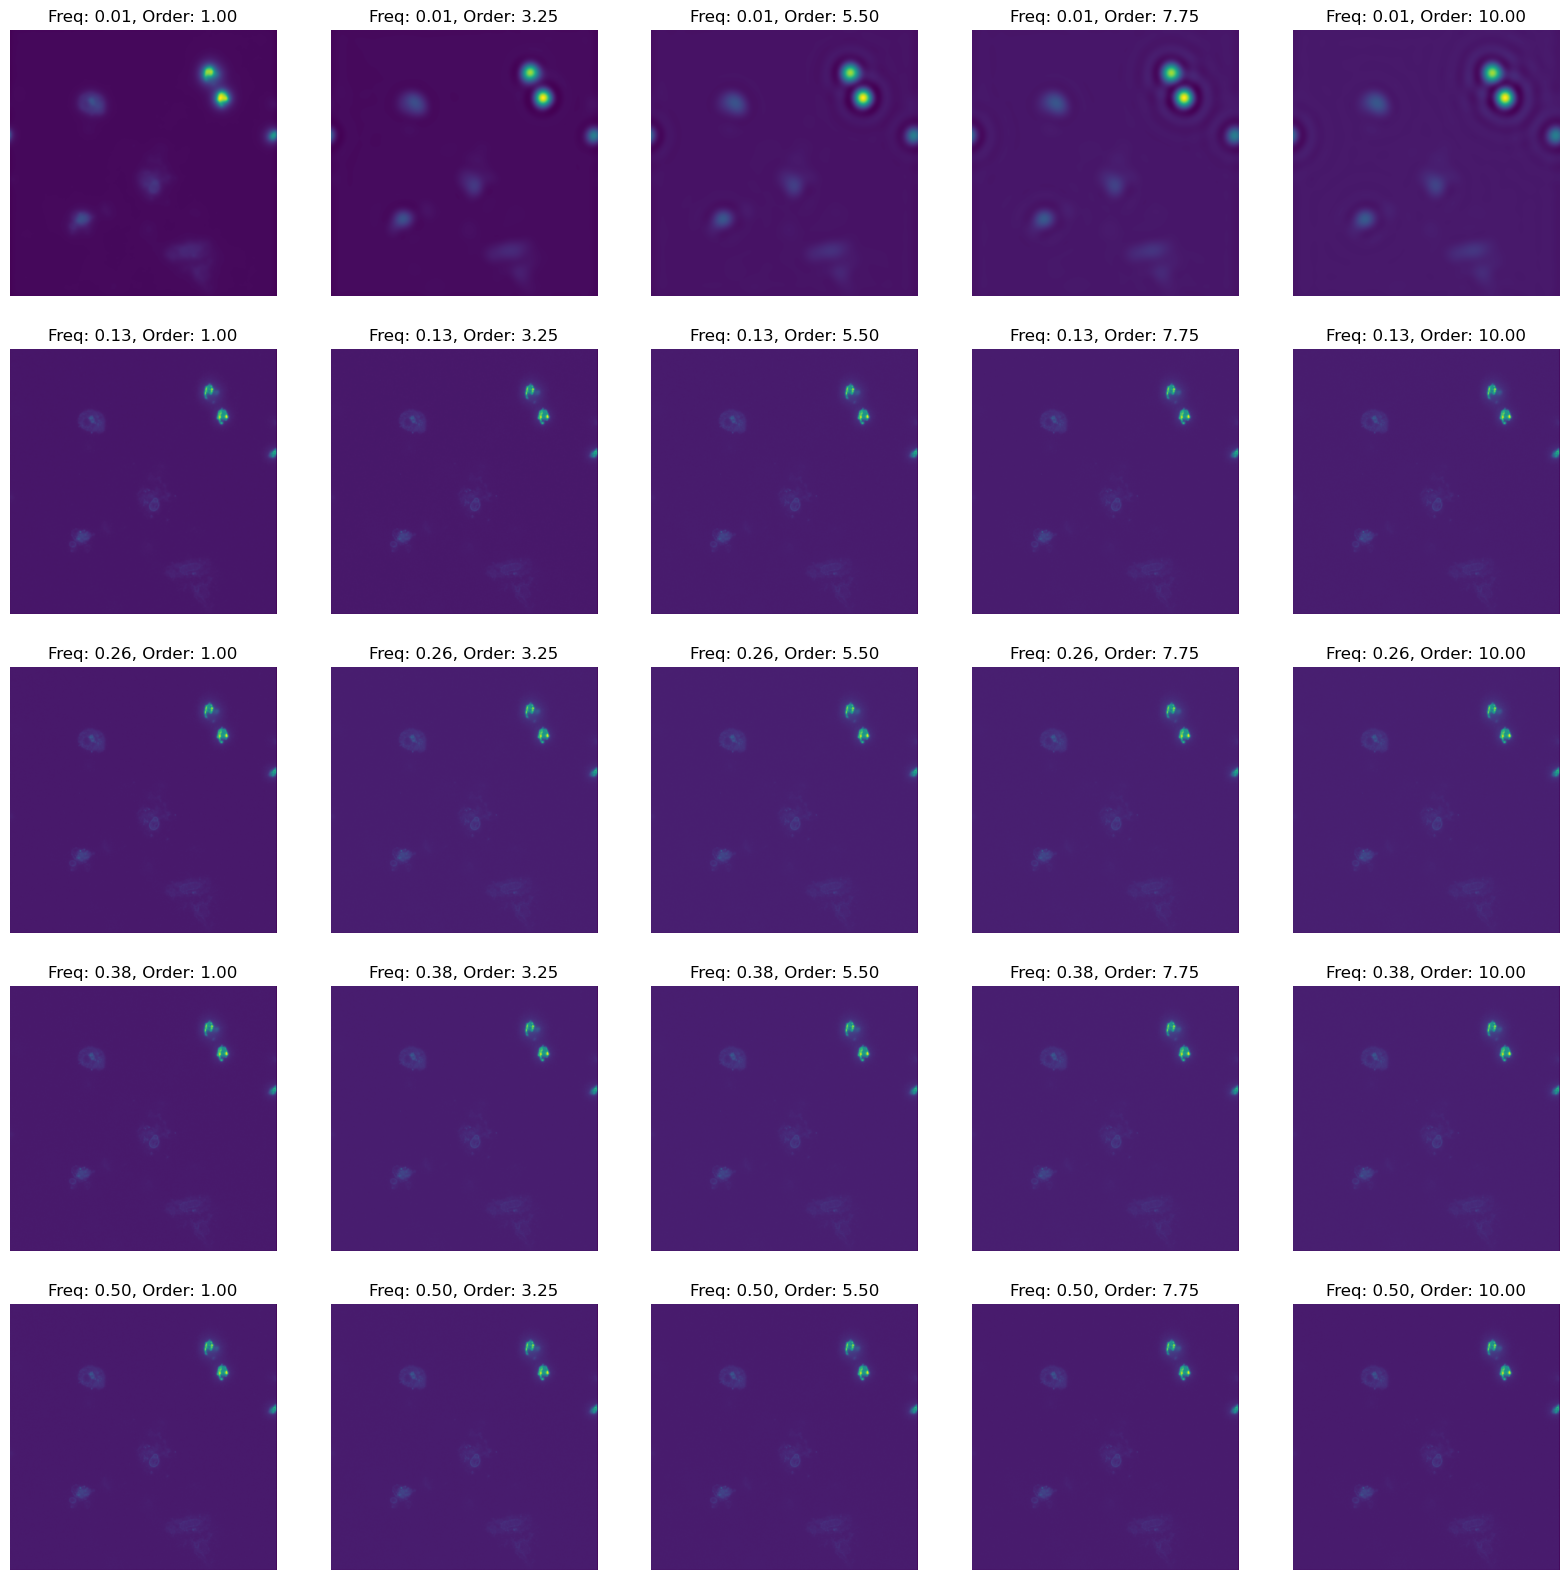

In [7]:
butterworth_optimization = True
if butterworth_optimization:
    # get the median most image from the cyto image stack
    # this is the image that will be used for the butterworth filter optimization
    # get the median image from the cyto image stack
    middle_index = int(cyto.shape[0] / 2)
    img_to_optimize = cyto[middle_index]
    optimization_steps = 5
    # optimize the butterworth filter for the cyto image
    search_space_cutoff_freq = np.linspace(0.01, 0.5, optimization_steps)
    search_space_order = np.linspace(1, 10, optimization_steps)
    # create a list of optimzation parameter pairs
    optimization_parameter_pairs = []
    for cutoff_freq_option in search_space_cutoff_freq:
        for order_option in search_space_order:
            optimization_parameter_pairs.append((cutoff_freq_option, order_option))
    print(
        f"Optimizing the butterworth filter for {len(optimization_parameter_pairs)} pairs"
    )
    optimized_images = []
    # loop through the optimization pairs to find the best pararmeters
    for cutoff_freq_option, order_option in tqdm.tqdm(optimization_parameter_pairs):
        optimized_images.append(
            skimage.filters.butterworth(
                img_to_optimize,
                cutoff_frequency_ratio=cutoff_freq_option,
                high_pass=False,
                order=order_option,
                squared_butterworth=True,
            )
        )
    if in_notebook:
        print("Optimization complete - plotting the results")
        # visualize the optimized images in a grid
        fig, ax = plt.subplots(optimization_steps, optimization_steps, figsize=(20, 20))
        for i in range(optimization_steps):
            for j in range(optimization_steps):
                ax[i, j].imshow(optimized_images[i * optimization_steps + j])
                ax[i, j].axis("off")
                # add the cutoff frequency and order to the plot
                ax[i, j].set_title(
                    f"Freq: {search_space_cutoff_freq[i]:.2f}, Order: {search_space_order[j]:.2f}"
                )
        plt.show()

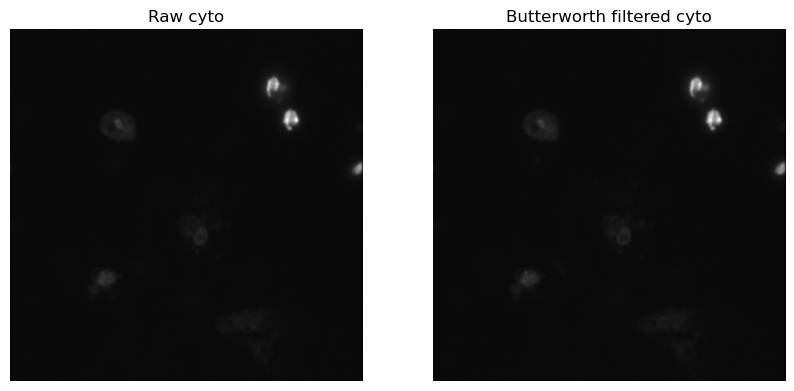

In [8]:
# # Use butterworth FFT filter to remove high frequency noise :)
for i in range(cyto.shape[0]):
    cyto[i, :, :] = skimage.filters.butterworth(
        cyto[i, :, :],
        cutoff_frequency_ratio=0.05,
        high_pass=False,
        order=1,
        squared_butterworth=True,
    )

# add a guassian blur to the image
imgs = skimage.filters.gaussian(cyto, sigma=1)
if in_notebook:
    # plot the nuclei and the cyto channels
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(cyto[middle_index, :, :], cmap="gray")
    plt.title("Raw cyto")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(imgs[middle_index, :, :], cmap="gray")
    plt.title("Butterworth filtered cyto")
    plt.axis("off")
    plt.show()

In [9]:
use_GPU = torch.cuda.is_available()
# Load the model
model_name = "cyto3"
model = models.CellposeModel(gpu=use_GPU, model_type=model_name)

output_dict = {
    "slice": [],
    "labels": [],
    "details": [],
}
# Iterate through slices and perform segmentation
for slice in tqdm.tqdm(range(imgs.shape[0])):
    # Perform segmentation of whole organoids with initial diameter of 750
    labels, details, _ = segment_with_diameter(
        imgs[slice, :, :],
        model=model,
        channels=[1, 0],
        z_axis=0,
        diameter=750,
    )

    # Append results to the output dictionary
    output_dict["slice"].append(slice)
    output_dict["labels"].append(labels)
    output_dict["details"].append(details)

100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


In [10]:
# reverse sliding window max projection
full_mask_z_stack = []
reconstruction_dict = {index: [] for index in range(original_cyto_z_count)}
print(f"Decoupling the sliding window max projection of {window_size} slices")

# decouple the sliding window max projection based on window size
# each slice in a stack
for z_stack_mask_index in range(len(output_dict["labels"])):
    # temoporary list to hold the decoupled z stack
    z_stack_decouple = []
    # decouple
    [
        z_stack_decouple.append(output_dict["labels"][z_stack_mask_index])
        for _ in range(window_size)
    ]
    # dull out the decouple slice to the correct z index
    for z_window_index, z_stack_mask in enumerate(z_stack_decouple):
        if not (z_stack_mask_index + z_window_index) >= original_cyto_z_count:
            reconstruction_dict[z_stack_mask_index + z_window_index].append(
                z_stack_mask
            )
# save the reconstruction_dict to a file for downstream decoupling
np.save(mask_path / "organoid_reconstruction_dict.npy", reconstruction_dict)

Decoupling the sliding window max projection of 4 slices


<Figure size 1000x500 with 0 Axes>

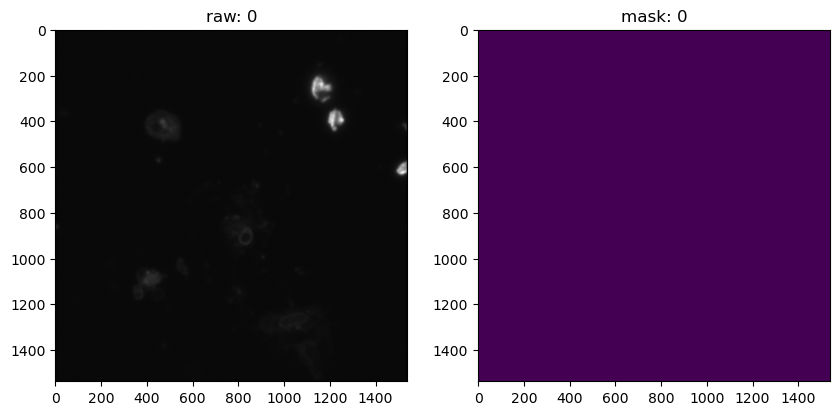

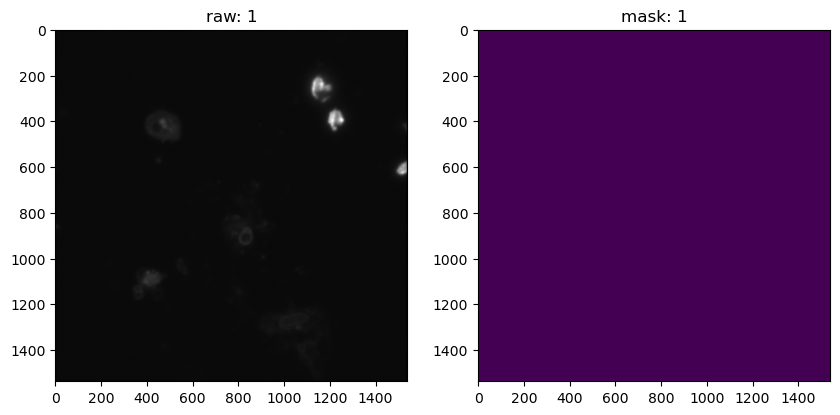

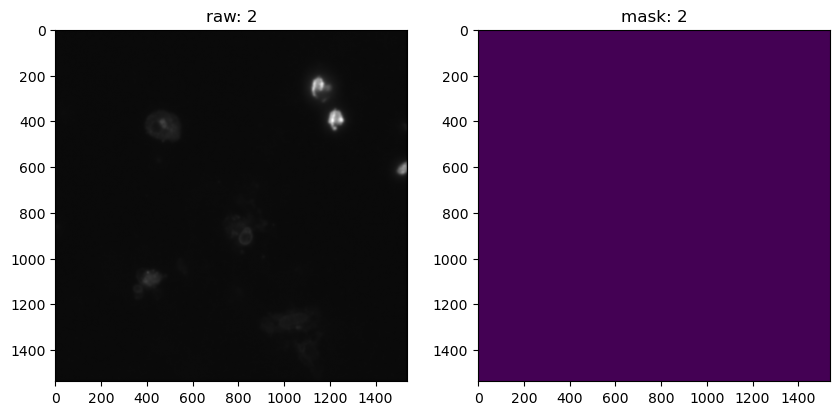

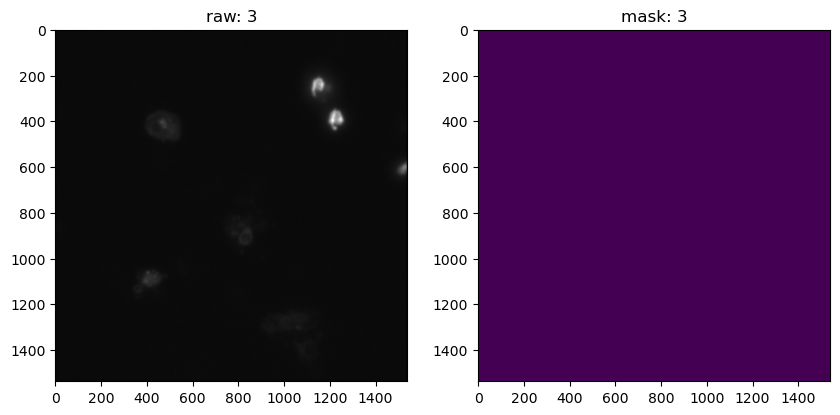

In [11]:
if in_notebook:
    # masks, flows, styles, diams
    plot = plt.figure(figsize=(10, 5))
    for z in range(len(output_dict["labels"])):
        plt.figure(figsize=(10, 10))
        plt.subplot(121)
        plt.imshow(imgs[z], cmap="gray")
        plt.title(f"raw: {z}")
        plt.subplot(122)
        plt.imshow(output_dict["labels"][z])
        plt.title(f"mask: {z}")
        plt.show()